In [1]:
# google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# The function for loading data
def load_LETOR4(file, num_features=46):
    '''
    :param file: the input file
    :param num_features: the number of features
    :return: the list of tuples, each tuple consists of qid, doc_reprs, doc_labels
    '''
  
    feature_cols = [str(f_index) for f_index in range(1, num_features + 1)]

    df = pd.read_csv(file, sep=" ", header=None)
    df.drop(columns=df.columns[[-2, -3, -5, -6, -8, -9]], axis=1, inplace=True)  # remove redundant keys
    assert num_features == len(df.columns) - 5

    for c in range(1, num_features +2): # remove keys per column from key:value
        df.iloc[:, c] = df.iloc[:, c].apply(lambda x: x.split(":")[1])

    df.columns = ['rele_truth', 'qid'] + feature_cols + ['#docid', 'inc', 'prob']

    for c in ['rele_truth'] + feature_cols:
        df[c] = df[c].astype(np.float32)

    df['rele_binary'] = (df['rele_truth'] > 0).astype(np.float32)  # additional binarized column for later filtering

    list_Qs = []
    qids = df.qid.unique()
    np.random.shuffle(qids)
    for qid in qids:
        sorted_qdf = df[df.qid == qid].sort_values('rele_truth', ascending=False)

        doc_reprs = sorted_qdf[feature_cols].values
        doc_labels = sorted_qdf['rele_truth'].values

        list_Qs.append((qid, doc_reprs, doc_labels))

    #if buffer: pickle_save(list_Qs, file=perquery_file)

    return list_Qs

In [4]:
# google clobal
# train_file = '/content/drive/My Drive/KLIS-MLIR-2020/Data/vali_as_train.txt'
# test_file = '/content/drive/My Drive/KLIS-MLIR-2020/Data/test.txt'

# local jupyter notebook
train_file = './vali_as_train.txt'
test_file = './test.txt'

train_list_Qs = load_LETOR4(file=train_file)
test_list_Qs = load_LETOR4(file=test_file)

In [5]:
def mean_squared_error(m, prediction, t):
    return (1/m) * np.sum( ( prediction - t ) **2 )

In [6]:
def gradient_descent(f, init_x, lr=0.01, step_num=20):
    parameter = init_x
    cost_history = np.zeros(step_num)
    
    for h in range(step_num):
        for (qid, train_X, train_Y) in train_list_Qs:
            for i in range(len(train_Y)):
                x = train_X[i, :] 
                y = train_Y[i]    
                prediction = np.dot(x, parameter)
                grad = 2/float(len(train_Y)) * (x * (prediction - y))

                parameter -= lr * grad
    
        cost=0
        for (qid, train_X, train_Y) in train_list_Qs:
            predictions_per_query = train_X.dot(parameter)
            m = len(train_Y)
            cost_per_query = mean_squared_error(m, predictions_per_query, train_Y)
            cost += cost_per_query
            # print(h, ":", cost)
        cost_history[h]  = cost # record the cost/loss per epoch

    return parameter, cost_history
 

In [7]:
def discounted_cumu_gain_at_k(sorted_labels, cutoff):
    '''
    :param sorted_labels: ranked labels (either standard or predicted by a system) in the form of np array
    :param max_cutoff: the maximum rank position to be considered
    :param multi_lavel_rele: either the case of multi-level relevance or the case of listwise int-value, e.g., MQ2007-list
    :return: cumulative gains for each rank position
    '''
    nums = np.power(2.0, sorted_labels[0:cutoff]) - 1.0
    denoms = np.log2(np.arange(cutoff) + 2.0)  # discounting factor
    dited_cumu_gain = np.sum(nums / denoms)

    return dited_cumu_gain

def ndcg_at_k(sys_sorted_labels, ideal_sorted_labels, k):
    sys_discounted_cumu_gain_at_k = discounted_cumu_gain_at_k(sys_sorted_labels, cutoff=k)
    ideal_discounted_cumu_gain_at_k = discounted_cumu_gain_at_k(ideal_sorted_labels, cutoff=k)
    ndcg_at_k = sys_discounted_cumu_gain_at_k / ideal_discounted_cumu_gain_at_k
    return ndcg_at_k

In [8]:
def evaluate(test_list_Qs, optimized_theta, k=20):
    nDCG=0.0
    count = 0.0 # count the number of test queries
    for (qid, test_X, test_Y) in test_list_Qs:
        sum_per_query = np.sum(test_Y)
        m = len(test_Y)
        if m < k or sum_per_query <= 0: # filter out queries that: (1) include less documents than k; (2) include no relevant documents
            continue
        else:
            count += 1
    
        predictions_per_query = test_X.dot(optimized_theta) # the predictions with respect to one query

        ideal_sorted_labels = np.sort(test_Y)               # the default is ascending order
        ideal_sorted_labels = np.flip(ideal_sorted_labels)  # convert to the descending order
    

        sorted_pred_indice = np.argsort(-predictions_per_query) # get the indice that sort the predictions in a descending order
        sys_sorted_labels = test_Y[sorted_pred_indice]          # get the corresponding ranking of standard labels 
    

        nDCG_per_query = ndcg_at_k(sys_sorted_labels=sys_sorted_labels, ideal_sorted_labels=ideal_sorted_labels, k=k)
        nDCG += nDCG_per_query

    nDCG = nDCG/count # using the average nDCG
    return nDCG

In [9]:
step_num = 20
X_Dimension = 46

debug = True # print some information if needed

init_x = np.random.randn(X_Dimension)
train_list_Qs = load_LETOR4(file=train_file)
optimized_theta, cost_history = gradient_descent(train_list_Qs, init_x, lr=0.01, step_num=step_num)

if debug:
  print('\n Optimized parameters:{}'.format(optimized_theta))



 Optimized parameters:[-1.27623752e-01 -1.38536961e-01  6.77130846e-01 -2.54086794e-01
  2.75158717e-01 -3.32398348e-02 -1.25653022e-01 -2.09343355e+00
  2.15596190e+00  1.04750692e+00 -9.13864950e-03  3.30249039e-02
 -7.95766888e-01  5.25303362e-01 -2.42634014e-01  4.25805559e-01
  8.98060187e-02  2.44756053e-04  7.55080214e-02 -2.66560067e-01
 -6.97336795e-01  3.79330880e-01  5.59105227e-01 -4.92943524e-01
  8.61724758e-02  5.69367098e-01  1.02506320e-01 -6.39229166e-01
  2.63727283e-01 -1.29281287e+00  3.38785465e-01  8.92102358e-01
 -2.48579458e-01 -8.90021484e-01  2.94399749e-01  5.72024745e-01
  8.55759626e-01  5.42279019e-02 -1.63582660e-01  1.76801171e-01
  7.03980538e-02 -1.22260900e-01  4.30650167e-02 -1.46882332e-01
 -1.76490391e-02  2.09826017e-01]


In [10]:
cost_history

array([242.13734297, 182.50493939, 157.8455399 , 144.67545246,
       136.49772554, 130.89664732, 126.80345341, 123.67605908,
       121.20967038, 119.21891989, 117.58379967, 116.22252098,
       115.0769264 , 114.10420236, 113.27193774, 112.55504455,
       111.93375912, 111.39229383, 110.91789699, 110.50017673])

In [11]:
test_list_Qs = load_LETOR4(file=test_file)
nDCG = evaluate(test_list_Qs=test_list_Qs, optimized_theta=optimized_theta)

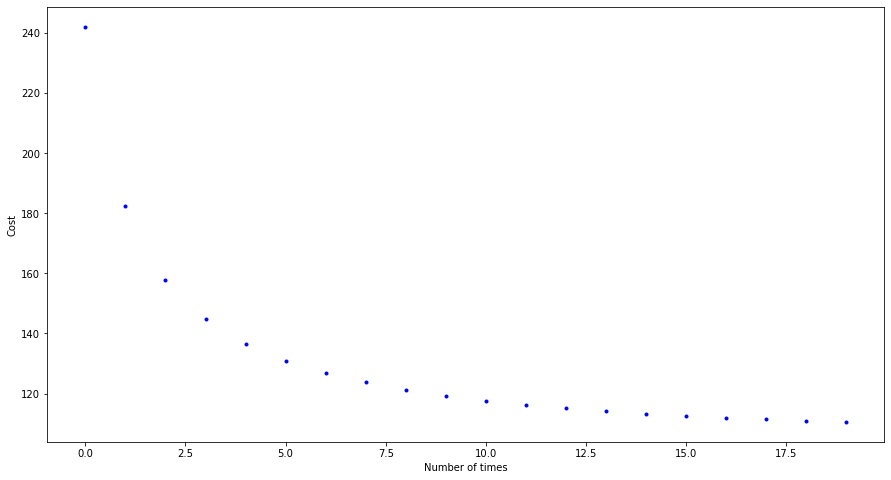

In [12]:
print()
fig, ax = plt.subplots(figsize=(15,8))
ax.set_ylabel('Cost')
ax.set_xlabel('Number of times')
ax.plot(range(step_num), cost_history[:step_num], 'b.')



In [13]:
!pip install ptranking

In [14]:
import torch
from ptranking.data.data_utils import LTRDataset, SPLIT_TYPE

In [15]:
import torch.nn as nn
from ptranking.base.ranker import NeuralRanker

mse = nn.MSELoss() # mean square error function provided by PyTorch

class MLIRMSE(NeuralRanker):
    def __init__(self, sf_para_dict=None, gpu=False, device=None):
        super(MLIRMSE, self).__init__(id='RankMSE', sf_para_dict=sf_para_dict, gpu=gpu, device=device)
        self.TL_AF = self.get_tl_af()

    def inner_train(self, batch_pred, batch_label, **kwargs):
        '''
        :param batch_preds: [batch, ranking_size] each row represents the relevance predictions for documents within a ltr_adhoc
        :param batch_stds: [batch, ranking_size] each row represents the standard relevance grades for documents within a ltr_adhoc
        :return:
        '''

        batch_loss = mse(batch_pred, batch_label)
        self.optimizer.zero_grad()	
        batch_loss.backward()
        self.optimizer.step()

        return batch_loss



In [16]:
from ptranking.ltr_adhoc.eval.parameter import ScoringFunctionParameter


class MLIRSFP(ScoringFunctionParameter):
    """
    The parameter class w.r.t. a neural scoring fuction
    """
    def __init__(self):
        super(MLIRSFP, self).__init__()

    def default_para_dict(self):
        """
        A default setting of the hyper-parameters of the stump neural scoring function.
        """
        # feed-forward neural networks
        ffnns_para_dict = dict(num_layers=5, HD_AF='R', HN_AF='R', TL_AF='S', apply_tl_af=True, BN=True, RD=False, FBN=False)

        sf_para_dict = dict()
        sf_para_dict['id'] = self.model_id
        sf_para_dict[self.model_id] = ffnns_para_dict

        self.sf_para_dict = sf_para_dict
        return sf_para_dict



In [17]:
from ptranking.data.data_utils import get_data_meta
from ptranking.ltr_adhoc.eval.eval_utils import ndcg_at_ks, ndcg_at_k
from ptranking.metric.adhoc_metric import torch_nDCG_at_k, torch_nDCG_at_ks

gpu, device = False, None

##- Data loading -##
# if colab
# file_train = '/content/drive/My Drive/Teaching/2020/KLIS-MLIR-2020/Data/vali_as_train.txt'

# file_test = '/content/drive/My Drive/Teaching/2020/KLIS-MLIR-2020/Data/test.txt'

# if local jupyter notebook
file_train = './vali_as_train.txt'
file_test = './test.txt'


train_data = LTRDataset(data_id='MQ2007_Super', file=file_train, split_type=SPLIT_TYPE.Train, batch_size=1, shuffle=True, presort=True, data_dict=None, eval_dict=None, buffer=False)

test_data = LTRDataset(data_id='MQ2007_Super', file=file_test, split_type=SPLIT_TYPE.Test, shuffle=False, data_dict=None, batch_size=1, buffer=False)

data_meta = get_data_meta(data_id='MQ2007_Super')

sf_para_dict = MLIRSFP().default_para_dict()

sf_para_dict['ffnns'].update(dict(num_features=data_meta['num_features']))


# Initialize the ranking class as a ranker
mlir_ranker = MLIRMSE(sf_para_dict=sf_para_dict)

# Training
epoch_loss = torch.cuda.FloatTensor([0.0]) if gpu else torch.FloatTensor([0.0])

# Training for each query
for qid, batch_rankings, batch_stds in train_data: # _, [batch, ranking_size, num_features], [batch, ranking_size]
    if gpu: batch_rankings, batch_stds = batch_rankings.to(device), batch_stds.to(device)

    batch_loss, stop_training = mlir_ranker.train(batch_rankings, batch_stds, qid=qid)

    #print(batch_loss)
    epoch_loss += batch_loss.item()


# Testing
ks=[1, 5, 10]
sum_ndcg_at_ks = torch.zeros(len(ks))
cnt = torch.zeros(1)
already_sorted = True if test_data.presort else False
for qid, batch_ranking, batch_labels in test_data: # _, [batch, ranking_size, num_features], [batch, ranking_size]

    if torch.sum(batch_labels) <=0: # filter dumb queries
      continue

    if gpu: batch_ranking = batch_ranking.to(device)
    batch_rele_preds = mlir_ranker.predict(batch_ranking)
    if gpu: batch_rele_preds = batch_rele_preds.cpu()

    _, batch_sorted_inds = torch.sort(batch_rele_preds, dim=1, descending=True)

    batch_sys_sorted_labels = torch.gather(batch_labels, dim=1, index=batch_sorted_inds)
    if already_sorted:
        batch_ideal_sorted_labels = batch_labels
    else:
        batch_ideal_sorted_labels, _ = torch.sort(batch_labels, dim=1, descending=True)

    batch_ndcg_at_ks = torch_nDCG_at_ks(batch_sys_sorted_labels=batch_sys_sorted_labels, batch_ideal_sorted_labels=batch_ideal_sorted_labels, ks=ks)

    # default batch_size=1 due to testing data
    sum_ndcg_at_ks = torch.add(sum_ndcg_at_ks, torch.squeeze(batch_ndcg_at_ks, dim=0))
    cnt += 1

avg_ndcg_at_ks = sum_ndcg_at_ks/cnt
print(avg_ndcg_at_ks)

tensor([0.4724, 0.4829, 0.5163])
